# **Load The Data** 
The pickled data is a dictionary with 4 key/value pairs:

- **features** is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- **labels** is a 1D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id.
- **sizes** is a list containing tuples, (width, height) representing the original width and height the image.
- **coords** is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. 

**THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [1]:
import pandas as pd
import numpy as np
# Load pickled data
import pickle
import warnings
warnings.filterwarnings('ignore')

training_file = "train.p"
validation_file="valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
#print(train)
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
# print("trainX")
# print(X_train[0:5])
# print("$$$$$$$$$$$$")
# print(y_train)
# print("$$$$$$$$$$$$")
train_sizes, train_coords = train['sizes'], train['coords']
valid_sizes, valid_coords = valid['sizes'], valid['coords']
test_sizes, test_coords = test['sizes'], test['coords']
# print("$$$$$$$$$$$$")
# print("trainsize")
# print(train_sizes)
# print("$$$$$$$$$$$$")
# print("train_coords")
# print(train_coords)
print("Done importing images.")


Done importing images.


# **Dataset Summary & Exploration**
**Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas**

In [2]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# the shape of a traffic sign image
image_shape = X_train[0].shape
image_shape_with_n_train =  X_train.shape
# numbre of classes/labels there are in the dataset.
n_classes = len(pd.Series(y_train).unique())

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


# **Data exploration visualization.**
Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from random import randint
# Visualizations will be shown in the notebook.
%matplotlib inline


In [4]:
#Load the signname csv file
signnames = pd.read_csv('./signnames.csv')
signnames.set_index('ClassId',inplace=True)

def get_name_from_label(label):
    # Helper, transofrm a numeric label into the corresponding strring
    return signnames.loc[label].SignName

In [5]:

counter = Counter(y_train)
print("Train example per class mean {} min {} max {}".format(int(np.mean(list(Counter(y_train).values()))),
                                                    np.min(list(Counter(y_train).values())) ,
                                                    np.max(list(Counter(y_train).values())) ))
print("Most common signs:")
for el in counter.most_common(10):
    print("'{}'".format(get_name_from_label(el[0])),' train samples: {}'.format(el[1]))
print()
print("Most rare signs:")
for el in sorted(counter.items(),key=lambda x: x[1])[:10]:
    print("'{}'".format(get_name_from_label(el[0])),' train samples: {}'.format(el[1]))



Train example per class mean 809 min 180 max 2010
Most common signs:
'Speed limit (50km/h)'  train samples: 2010
'Speed limit (30km/h)'  train samples: 1980
'Yield'  train samples: 1920
'Priority road'  train samples: 1890
'Keep right'  train samples: 1860
'No passing for vehicles over 3.5 metric tons'  train samples: 1800
'Speed limit (70km/h)'  train samples: 1770
'Speed limit (80km/h)'  train samples: 1650
'Road work'  train samples: 1350
'No passing'  train samples: 1320

Most rare signs:
'Go straight or left'  train samples: 180
'Dangerous curve to the left'  train samples: 180
'Speed limit (20km/h)'  train samples: 180
'End of no passing'  train samples: 210
'End of no passing by vehicles over 3.5 metric tons'  train samples: 210
'End of all speed and passing limits'  train samples: 210
'Pedestrians'  train samples: 210
'Bicycles crossing'  train samples: 240
'Road narrows on the right'  train samples: 240
'Keep left'  train samples: 270


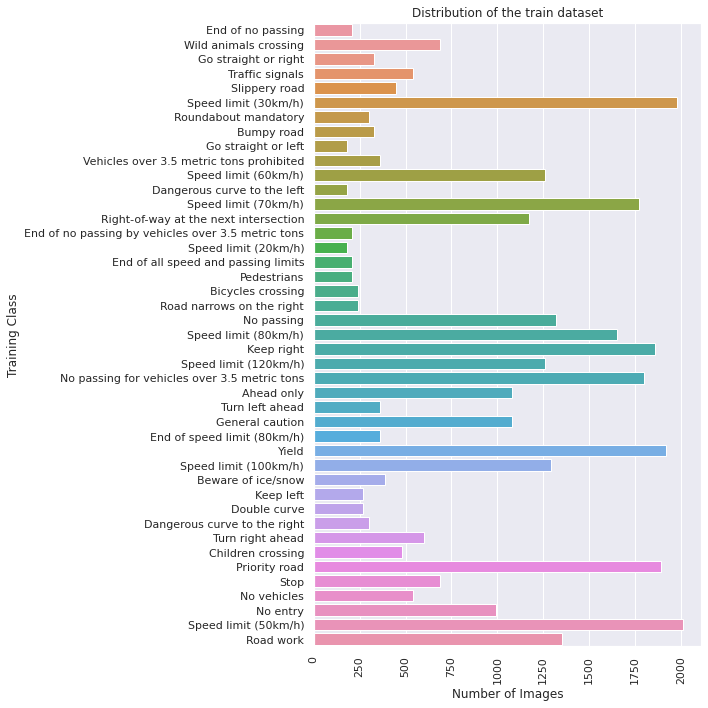

In [6]:

# Distribution of images per class 
counts = pd.DataFrame(columns=['sign_label','training_samples_count'],data=[(label, count) for label, count in counter.items()])
counts['sign'] = counts.sign_label.apply(get_name_from_label)

plt.figure(figsize=(10,10))
sns.set(font_scale=1)
sns.barplot(data=counts,x='training_samples_count',y='sign')
plt.xticks(rotation=90)
plt.ylabel('Training Class')
plt.xlabel('Number of Images');
plt.title("Distribution of the train dataset")
plt.tight_layout()
#plt.savefig('training_set_counts.png')



#generate random image max 5 raw & clos

In [7]:
"""

def get_random_samples(n_max):
    selected = list()
    n_raw=5
    for current_label in range(n_raw):
        found=0
        while found<n_max:
            ii = np.random.randint(len(y_train))
            
            if current_label == y_train[ii]:
                selected.append(ii)
                found+=1

    assert len(selected) ==  n_raw*n_max
    return list(selected)
    plt.figure(figsize=(12, 16))



count=0
cols = 10
for ii in get_random_samples(cols):
    count+=1
    plt.subplot(5,cols,count)
    plt.imshow(X_train[ii])
    plt.axis('off')
plt.tight_layout()
#plt.savefig('random_examples.png')

"""

"\n\ndef get_random_samples(n_max):\n    selected = list()\n    n_raw=5\n    for current_label in range(n_raw):\n        found=0\n        while found<n_max:\n            ii = np.random.randint(len(y_train))\n            \n            if current_label == y_train[ii]:\n                selected.append(ii)\n                found+=1\n\n    assert len(selected) ==  n_raw*n_max\n    return list(selected)\n    plt.figure(figsize=(12, 16))\n\n\n\ncount=0\ncols = 10\nfor ii in get_random_samples(cols):\n    count+=1\n    plt.subplot(5,cols,count)\n    plt.imshow(X_train[ii])\n    plt.axis('off')\nplt.tight_layout()\n#plt.savefig('random_examples.png')\n\n"

#**Pre-process the Data Set (normalization, etc.)** 
Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data,

In [8]:
import cv2
from sklearn.utils import shuffle
from skimage.transform import resize
from skimage.transform import rotate
from skimage.color import rgb2gray

In [9]:
#generate random value of image
def someRandomImageId(nb = n_train):
    return int(np.random.rand()*nb)

#normalize the data
def normalize_features_pos(img_):
    return (img_-img_.mean())/(np.max(img_)-np.min(img_))

#resize the data to (32,32)
def resizeSize(img, x=32, y=32):
    return cv2.resize(img,(x, y), interpolation = cv2.INTER_CUBIC)

#crop roi in image
def crop(img, ROI):
    return img[(ROI[1]):(ROI[3]),(ROI[0]):(ROI[2])]

#add a new roi
def addROI(img, ROI, color=(255,0, 0)):
    copy = img.copy()
    return cv2.rectangle(copy,(ROI[0],ROI[1]),(ROI[2],ROI[3]),color)


# rectify Coords  for selecting ROI
def rectifyCoords(nb, sizes, coords):
    rectified = []
    for j in range(0, nb):
        x_ratio = image_shape_with_n_train[1] / sizes[j][0]
        y_ratio = image_shape_with_n_train[2] / sizes[j][1]
        rectified.append((int(coords[j][0]*x_ratio), int(coords[j][1]*y_ratio), \
                          int(coords[j][2]*x_ratio), int(coords[j][3]*y_ratio)))
    return rectified
    
#Augmenting function
def augment_img(img,ROI):
    #crop ROI 
    crop_ROI = crop(img, ROI)
    #Resize ROI (32,32)
    Resized_ROI=resizeSize(crop_ROI)
    #normalize ROI
    normalize_ROI=normalize_features_pos(Resized_ROI)
    #Rotate ROI by a small angle [-15°, 15°] 
    rotated_ROI = rotate(normalize_ROI,np.random.rand()*30-15)
    #GrayScal
    #GrayScal_ROI = rgb2gray(rotated_ROI)
    
    return rotated_ROI

#print Augmenting image
def plotAugmentation(*argv, figsize=(20, 5), save=None):
    fig = plt.figure(figsize=figsize)
    for i in range(0, len(argv[0])):    
        ax=fig.add_subplot(1,len(argv[0]),i+1)        
        ax.imshow(argv[0][i][1])
        ax.set_title(argv[0][i][0])
    if save != None:
        plt.savefig(save)
    plt.show() 


rectified_train_coords = rectifyCoords(n_train, train_sizes, train_coords)
rectified_valid_coords = rectifyCoords(n_validation, valid_sizes, valid_coords)
rectified_test_coords  = rectifyCoords(n_test,  test_sizes,  test_coords)

print("Augmenting functions defined.")


Augmenting functions defined.


# **Region of interst Cropping** &  **Normalize**
- Neural networks offer much better results when the data is normalized because it creates more variation in the data values. Practically speaking normalizing the data means that the input values range from -1 to 1 instead of being between 0 and 255 in the case of images.
- In order to add more training data and to make the network more accurate, I rotate randomly the images by a small angle [-15°, 15°] around the center of the Region Of Interest.

(32, 32, 3)


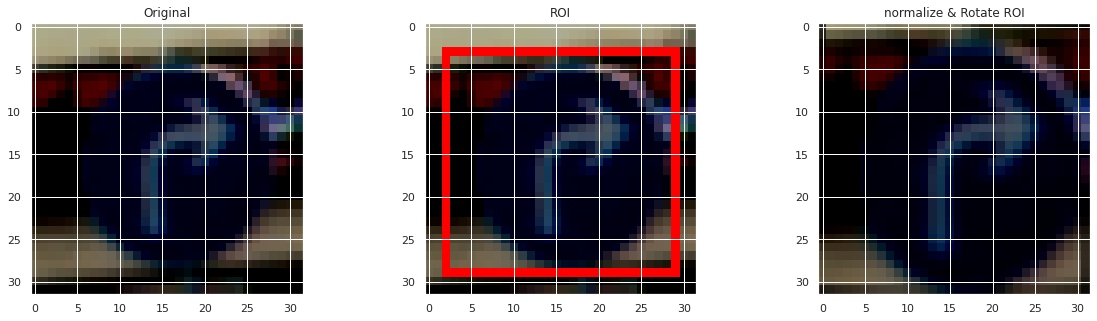

In [39]:

i = someRandomImageId()
#print(i)
#i=10852
arguments = (('Original', X_train[i]), ('ROI', addROI(X_train[i], rectified_train_coords[i])),('normalize & Rotate ROI', augment_img(X_train[i], rectified_train_coords[i])))
print(augment_img(X_train[i], rectified_train_coords[i]).shape)
plotAugmentation(arguments)



#**Pre-processing All The Dataset**

In [11]:
#Training data splitting for validation dataset

X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)


In [12]:
X_train = normalize_features_pos(X_train)
X_valid = normalize_features_pos(X_valid)
X_test = normalize_features_pos(X_test)

In [13]:
"""
#Augmented All dataset Using the augmented function

X_train_transf =[]
y_train_transf = []

for ii in range(0,num_img_needed):
    img = X_train[ii]
    label = y_train[ii]
    imgout = augment_img(img, rectified_train_coords[ii])
    imgout.shape = (1,) + imgout.shape + (1,)
    X_train_transf.append(imgout)
    y_train_transf.append(label)
    for j in range(10):
        imgout = augment_img(img, rectified_train_coords[ii])
        imgout.shape = (1,) + imgout.shape + (1,)
        X_train_transf.append(imgout)
        y_train_transf.append(label)



X_train_transf = np.concatenate(X_train_transf,axis=0)
y_train_transf = np.array(y_train_transf)


X_test_transf = []
X_valid_transf = []

for ii in range(X_valid.shape[0]):
    img = X_valid[ii]
    img = augment_img(img, rectified_train_coords[ii])
    img.shape = (1,) + img.shape + (1,)
    X_valid_transf.append(img)
    
for ii in range(X_test.shape[0]):
    img = X_test[ii]
    img = augment_img(img, rectified_train_coords[ii])
    img.shape = (1,) + img.shape + (1,)
    X_test_transf.append(img)


X_test_transf = np.concatenate(X_test_transf,axis=0)
X_valid_transf = np.concatenate(X_valid_transf,axis=0)


"""

'\n#Augmented All dataset Using the augmented function\n\nX_train_transf =[]\ny_train_transf = []\n\nfor ii in range(0,num_img_needed):\n    img = X_train[ii]\n    label = y_train[ii]\n    imgout = augment_img(img, rectified_train_coords[ii])\n    imgout.shape = (1,) + imgout.shape + (1,)\n    X_train_transf.append(imgout)\n    y_train_transf.append(label)\n    for j in range(10):\n        imgout = augment_img(img, rectified_train_coords[ii])\n        imgout.shape = (1,) + imgout.shape + (1,)\n        X_train_transf.append(imgout)\n        y_train_transf.append(label)\n\n\n\nX_train_transf = np.concatenate(X_train_transf,axis=0)\ny_train_transf = np.array(y_train_transf)\n\n\nX_test_transf = []\nX_valid_transf = []\n\nfor ii in range(X_valid.shape[0]):\n    img = X_valid[ii]\n    img = augment_img(img, rectified_train_coords[ii])\n    img.shape = (1,) + img.shape + (1,)\n    X_valid_transf.append(img)\n    \nfor ii in range(X_test.shape[0]):\n    img = X_test[ii]\n    img = augment_img

# **Model Architecture**

 **LeNet**
 


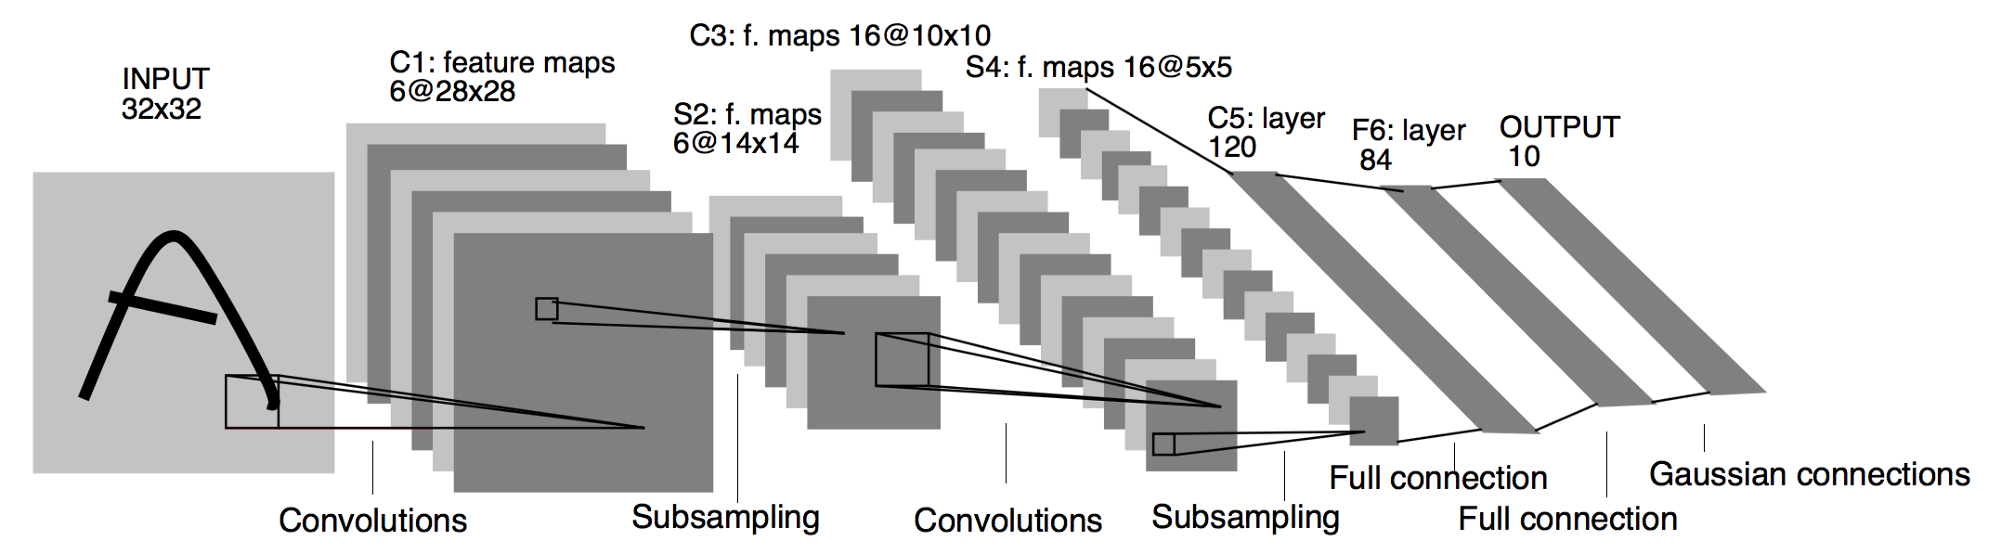

In [14]:
!pip install --upgrade tf_slim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 352 kB 33.0 MB/s 


In [15]:
import tensorflow as tf
import tf_slim as slim
tf.compat.v1.disable_eager_execution()

In [16]:
#Test GPU 
#tf.test.gpu_device_name()

In [17]:
def LeNet(x): 
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.compat.v1.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # Activation 1. using relu Activation Function
    conv1 = tf.nn.relu(conv1)

    # Max Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    
    # Layer 2: Convolutional. Input = 14x14x6. Output = 10x10x16.
    conv2_W = tf.Variable(tf.compat.v1.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation 2.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    #Flatten Input : reduces the input data into a single dimension 5x5x16 = 400
    # Flatten. Input = 5x5x16. Output = 400.
    flattened   = slim.flatten(conv2)
    
    #Matrix multiplication
    #input: 1x400
    #weight: 400x120 
    #Matrix multiplication(dot product rule)
    #output = 1x400 * 400*120 => 1x120
    
     # Layer 3: Fully Connected. Input = 400. Output = 120.
    fullyc1_W = tf.Variable(tf.compat.v1.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fullyc1_b = tf.Variable(tf.zeros(120))
    fullyc1   = tf.matmul(flattened, fullyc1_W) + fullyc1_b
    
    # Full connected layer activation 1.
    fullyc1    = tf.nn.relu(fullyc1)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fullyc2_W  = tf.Variable(tf.compat.v1.truncated_normal(shape=(120, 84), mean = 0, stddev = 0.1))
    fullyc2_b  = tf.Variable(tf.zeros(84))
    fullyc2    = tf.matmul(fullyc1, fullyc2_W) + fullyc2_b
    
    # Full connected layer activation 2.
    fullyc2    = tf.nn.relu(fullyc2)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fullyc3_W  = tf.Variable(tf.compat.v1.truncated_normal(shape=(84, 43), mean = 0, stddev = 0.1))
    fullyc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fullyc2, fullyc3_W) + fullyc3_b
    
    return logits

print("Model defined.")

Model defined.


# **Features and Labels**
x is a placeholder for a batch of input images. y is a placeholder for a batch of output labels. .

In [18]:
x = tf.compat.v1.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.compat.v1.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

# **Train & Validate the Model**
A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [19]:
"""      
Hyper parameters

"""

#learning rates745
learning_rate = 0.001
#the number of times the algorithm sees the entire data set
epochs = 42
#the number of samples (inputs) that will be passed through to the network at one time.
batch_size = 128


In [20]:
logits = LeNet(x)
#relation between probabilities and Erreur function CE
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)
predict_operation = tf.argmax(logits, 1)
predict_proba_operation = tf.nn.softmax(logits=logits)

# **Model Evaluation**
Evaluate how well the accuracy of the model for a given dataset.

In [21]:
correct_prediction = tf.equal(predict_operation, tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.compat.v1.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_loss/num_examples, total_accuracy/num_examples

print("Evaluate function defined.")

Evaluate function defined.


In [22]:
from sklearn.utils import shuffle
from time import time
import logging, datetime

In [23]:

"""
Log File for Metadata 
"""
logger = logging.getLogger()
#create file handler for logger
def setup_file_logger(log_file):
    hdlr = logging.FileHandler(log_file)
    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
    hdlr.setFormatter(formatter)
    logger.addHandler(hdlr) 
    logger.setLevel(logging.INFO)

def log(message):
    #outputs to Colab console
    print('{} {}'.format(datetime.datetime.now(), message))
    #outputs to file
    logger.info(message)

setup_file_logger('training_Modul.log')

# **Train the Model**

In [24]:
# tf.compat.v1.reset_default_graph()

In [25]:
validation_accuracy = []
validation_loss = []
training_accuracy = []
training_loss = []
saver1 = tf.compat.v1.train.Saver()
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Start Training...")
    print("Number of epochs : {}".format(epochs))
    print("Batch size : {}".format(batch_size))
    print("Learning rate : {}".format(learning_rate))
    print()
    

    for i in range(epochs):
      try:
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, batch_size):
                end = offset + batch_size
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
                        
            log("EPOCH {} ...".format(i+1))
            # Training data
            train_loss, train_accuracy = evaluate(X_train, y_train)
            training_accuracy.append(train_accuracy)
            training_loss.append(train_loss)
            log("Training Accuracy = {:.3f}".format(train_accuracy))
            print("Training error = {:.3f} ".format( train_loss ))
            # Validation data
            valid_loss, valid_accuracy = evaluate(X_valid, y_valid)
            validation_accuracy.append(valid_accuracy)
            validation_loss.append(valid_loss)
            log("Validation Accuracy = {:.3f}".format(valid_accuracy))
            print("Validation error = {:.3f}".format(valid_loss))
            print()


      except KeyboardInterrupt:
          test_loss, test_accuracy = evaluate(X_valid, y_valid)
          log('Accuracy Model On Test Images: {}'.format(test_accuracy))
          print('Loss Model On Test Images: {}'.format(test_loss))   
          break

        
    saver1.save(sess, 'LeNet_Modul')
    print("Model saved")

Start Training...
Number of epochs : 42
Batch size : 128
Learning rate : 0.001



INFO:root:EPOCH 1 ...


2022-08-14 18:40:31.454940 EPOCH 1 ...


INFO:root:Training Accuracy = 0.777
INFO:root:Validation Accuracy = 0.697


2022-08-14 18:40:32.767620 Training Accuracy = 0.777
Training error = 0.777 
2022-08-14 18:40:32.919201 Validation Accuracy = 0.697
Validation error = 1.051



INFO:root:EPOCH 2 ...


2022-08-14 18:40:34.598298 EPOCH 2 ...


INFO:root:Training Accuracy = 0.905
INFO:root:Validation Accuracy = 0.807


2022-08-14 18:40:35.594230 Training Accuracy = 0.905
Training error = 0.338 
2022-08-14 18:40:35.727573 Validation Accuracy = 0.807
Validation error = 0.702



INFO:root:EPOCH 3 ...


2022-08-14 18:40:37.348044 EPOCH 3 ...


INFO:root:Training Accuracy = 0.947
INFO:root:Validation Accuracy = 0.863


2022-08-14 18:40:38.425358 Training Accuracy = 0.947
Training error = 0.201 
2022-08-14 18:40:38.586245 Validation Accuracy = 0.863
Validation error = 0.575



INFO:root:EPOCH 4 ...


2022-08-14 18:40:40.866983 EPOCH 4 ...


INFO:root:Training Accuracy = 0.963
INFO:root:Validation Accuracy = 0.878


2022-08-14 18:40:41.826536 Training Accuracy = 0.963
Training error = 0.140 
2022-08-14 18:40:41.956440 Validation Accuracy = 0.878
Validation error = 0.568



INFO:root:EPOCH 5 ...


2022-08-14 18:40:43.535313 EPOCH 5 ...


INFO:root:Training Accuracy = 0.975
INFO:root:Validation Accuracy = 0.878


2022-08-14 18:40:44.538138 Training Accuracy = 0.975
Training error = 0.101 
2022-08-14 18:40:44.675634 Validation Accuracy = 0.878
Validation error = 0.521



INFO:root:EPOCH 6 ...


2022-08-14 18:40:46.384474 EPOCH 6 ...


INFO:root:Training Accuracy = 0.973
INFO:root:Validation Accuracy = 0.875


2022-08-14 18:40:47.432304 Training Accuracy = 0.973
Training error = 0.095 
2022-08-14 18:40:47.583513 Validation Accuracy = 0.875
Validation error = 0.625



INFO:root:EPOCH 7 ...


2022-08-14 18:40:49.299981 EPOCH 7 ...


INFO:root:Training Accuracy = 0.980
INFO:root:Validation Accuracy = 0.880


2022-08-14 18:40:50.406194 Training Accuracy = 0.980
Training error = 0.071 
2022-08-14 18:40:50.515743 Validation Accuracy = 0.880
Validation error = 0.567



INFO:root:EPOCH 8 ...


2022-08-14 18:40:52.070037 EPOCH 8 ...


INFO:root:Training Accuracy = 0.988
INFO:root:Validation Accuracy = 0.895


2022-08-14 18:40:53.113747 Training Accuracy = 0.988
Training error = 0.051 
2022-08-14 18:40:53.242618 Validation Accuracy = 0.895
Validation error = 0.508



INFO:root:EPOCH 9 ...


2022-08-14 18:40:54.715361 EPOCH 9 ...


INFO:root:Training Accuracy = 0.985
INFO:root:Validation Accuracy = 0.873


2022-08-14 18:40:55.821724 Training Accuracy = 0.985
Training error = 0.053 
2022-08-14 18:40:55.957629 Validation Accuracy = 0.873
Validation error = 0.663



INFO:root:EPOCH 10 ...


2022-08-14 18:40:57.585703 EPOCH 10 ...


INFO:root:Training Accuracy = 0.990
INFO:root:Validation Accuracy = 0.885


2022-08-14 18:40:58.365855 Training Accuracy = 0.990
Training error = 0.038 
2022-08-14 18:40:58.472578 Validation Accuracy = 0.885
Validation error = 0.647



INFO:root:EPOCH 11 ...


2022-08-14 18:40:59.632765 EPOCH 11 ...


INFO:root:Training Accuracy = 0.990
INFO:root:Validation Accuracy = 0.890


2022-08-14 18:41:00.297997 Training Accuracy = 0.990
Training error = 0.035 
2022-08-14 18:41:00.389279 Validation Accuracy = 0.890
Validation error = 0.732



INFO:root:EPOCH 12 ...


2022-08-14 18:41:01.490302 EPOCH 12 ...


INFO:root:Training Accuracy = 0.994
INFO:root:Validation Accuracy = 0.908


2022-08-14 18:41:02.146113 Training Accuracy = 0.994
Training error = 0.025 
2022-08-14 18:41:02.235726 Validation Accuracy = 0.908
Validation error = 0.576



INFO:root:EPOCH 13 ...


2022-08-14 18:41:03.304467 EPOCH 13 ...


INFO:root:Training Accuracy = 0.995
INFO:root:Validation Accuracy = 0.912


2022-08-14 18:41:03.968758 Training Accuracy = 0.995
Training error = 0.019 
2022-08-14 18:41:04.058367 Validation Accuracy = 0.912
Validation error = 0.553



INFO:root:EPOCH 14 ...


2022-08-14 18:41:05.122149 EPOCH 14 ...


INFO:root:Training Accuracy = 0.996
INFO:root:Validation Accuracy = 0.902


2022-08-14 18:41:05.787017 Training Accuracy = 0.996
Training error = 0.016 
2022-08-14 18:41:05.877057 Validation Accuracy = 0.902
Validation error = 0.628



INFO:root:EPOCH 15 ...


2022-08-14 18:41:06.979503 EPOCH 15 ...


INFO:root:Training Accuracy = 0.997
INFO:root:Validation Accuracy = 0.918


2022-08-14 18:41:07.643015 Training Accuracy = 0.997
Training error = 0.013 
2022-08-14 18:41:07.730088 Validation Accuracy = 0.918
Validation error = 0.557



INFO:root:EPOCH 16 ...


2022-08-14 18:41:08.801452 EPOCH 16 ...


INFO:root:Training Accuracy = 0.991
INFO:root:Validation Accuracy = 0.901


2022-08-14 18:41:09.452296 Training Accuracy = 0.991
Training error = 0.032 
2022-08-14 18:41:09.537779 Validation Accuracy = 0.901
Validation error = 0.757



INFO:root:EPOCH 17 ...


2022-08-14 18:41:10.624920 EPOCH 17 ...


INFO:root:Training Accuracy = 0.998
INFO:root:Validation Accuracy = 0.918


2022-08-14 18:41:11.275547 Training Accuracy = 0.998
Training error = 0.008 
2022-08-14 18:41:11.362998 Validation Accuracy = 0.918
Validation error = 0.572



INFO:root:EPOCH 18 ...


2022-08-14 18:41:12.448935 EPOCH 18 ...


INFO:root:Training Accuracy = 0.995
INFO:root:Validation Accuracy = 0.905


2022-08-14 18:41:13.129690 Training Accuracy = 0.995
Training error = 0.017 
2022-08-14 18:41:13.218115 Validation Accuracy = 0.905
Validation error = 0.640



INFO:root:EPOCH 19 ...


2022-08-14 18:41:14.330523 EPOCH 19 ...


INFO:root:Training Accuracy = 0.995
INFO:root:Validation Accuracy = 0.900


2022-08-14 18:41:14.993972 Training Accuracy = 0.995
Training error = 0.019 
2022-08-14 18:41:15.081484 Validation Accuracy = 0.900
Validation error = 0.731



INFO:root:EPOCH 20 ...


2022-08-14 18:41:16.163411 EPOCH 20 ...


INFO:root:Training Accuracy = 0.992
INFO:root:Validation Accuracy = 0.907


2022-08-14 18:41:16.831470 Training Accuracy = 0.992
Training error = 0.028 
2022-08-14 18:41:16.919344 Validation Accuracy = 0.907
Validation error = 0.715



INFO:root:EPOCH 21 ...


2022-08-14 18:41:17.972448 EPOCH 21 ...


INFO:root:Training Accuracy = 0.998
INFO:root:Validation Accuracy = 0.895


2022-08-14 18:41:18.619802 Training Accuracy = 0.998
Training error = 0.006 
2022-08-14 18:41:18.707841 Validation Accuracy = 0.895
Validation error = 0.828



INFO:root:EPOCH 22 ...


2022-08-14 18:41:19.770459 EPOCH 22 ...


INFO:root:Training Accuracy = 0.993
INFO:root:Validation Accuracy = 0.897


2022-08-14 18:41:20.457714 Training Accuracy = 0.993
Training error = 0.025 
2022-08-14 18:41:20.546908 Validation Accuracy = 0.897
Validation error = 0.764



INFO:root:EPOCH 23 ...


2022-08-14 18:41:21.648105 EPOCH 23 ...


INFO:root:Training Accuracy = 0.997
INFO:root:Validation Accuracy = 0.905


2022-08-14 18:41:22.313666 Training Accuracy = 0.997
Training error = 0.010 
2022-08-14 18:41:22.405570 Validation Accuracy = 0.905
Validation error = 0.707



INFO:root:EPOCH 24 ...


2022-08-14 18:41:23.479892 EPOCH 24 ...


INFO:root:Training Accuracy = 0.996
INFO:root:Validation Accuracy = 0.924


2022-08-14 18:41:24.319079 Training Accuracy = 0.996
Training error = 0.012 
2022-08-14 18:41:24.434247 Validation Accuracy = 0.924
Validation error = 0.586



INFO:root:EPOCH 25 ...


2022-08-14 18:41:25.492329 EPOCH 25 ...


INFO:root:Training Accuracy = 0.996
INFO:root:Validation Accuracy = 0.924


2022-08-14 18:41:26.160571 Training Accuracy = 0.996
Training error = 0.015 
2022-08-14 18:41:26.249823 Validation Accuracy = 0.924
Validation error = 0.560



INFO:root:EPOCH 26 ...


2022-08-14 18:41:27.352450 EPOCH 26 ...


INFO:root:Training Accuracy = 0.997
INFO:root:Validation Accuracy = 0.926


2022-08-14 18:41:28.033824 Training Accuracy = 0.997
Training error = 0.009 
2022-08-14 18:41:28.126790 Validation Accuracy = 0.926
Validation error = 0.582



INFO:root:EPOCH 27 ...


2022-08-14 18:41:29.194429 EPOCH 27 ...


INFO:root:Training Accuracy = 0.998
INFO:root:Validation Accuracy = 0.921


2022-08-14 18:41:29.854799 Training Accuracy = 0.998
Training error = 0.008 
2022-08-14 18:41:29.947882 Validation Accuracy = 0.921
Validation error = 0.707



INFO:root:EPOCH 28 ...


2022-08-14 18:41:31.039542 EPOCH 28 ...


INFO:root:Training Accuracy = 0.999
INFO:root:Validation Accuracy = 0.934


2022-08-14 18:41:31.695102 Training Accuracy = 0.999
Training error = 0.004 
2022-08-14 18:41:31.786623 Validation Accuracy = 0.934
Validation error = 0.440



INFO:root:EPOCH 29 ...


2022-08-14 18:41:32.888425 EPOCH 29 ...


INFO:root:Training Accuracy = 1.000
INFO:root:Validation Accuracy = 0.931


2022-08-14 18:41:33.553346 Training Accuracy = 1.000
Training error = 0.001 
2022-08-14 18:41:33.645076 Validation Accuracy = 0.931
Validation error = 0.530



INFO:root:EPOCH 30 ...


2022-08-14 18:41:34.711923 EPOCH 30 ...


INFO:root:Training Accuracy = 0.992
INFO:root:Validation Accuracy = 0.914


2022-08-14 18:41:35.376451 Training Accuracy = 0.992
Training error = 0.025 
2022-08-14 18:41:35.465913 Validation Accuracy = 0.914
Validation error = 0.591



INFO:root:EPOCH 31 ...


2022-08-14 18:41:36.533641 EPOCH 31 ...


INFO:root:Training Accuracy = 0.999
INFO:root:Validation Accuracy = 0.925


2022-08-14 18:41:37.198624 Training Accuracy = 0.999
Training error = 0.004 
2022-08-14 18:41:37.284539 Validation Accuracy = 0.925
Validation error = 0.546



INFO:root:EPOCH 32 ...


2022-08-14 18:41:38.389792 EPOCH 32 ...


INFO:root:Training Accuracy = 1.000
INFO:root:Validation Accuracy = 0.925


2022-08-14 18:41:39.045931 Training Accuracy = 1.000
Training error = 0.001 
2022-08-14 18:41:39.135573 Validation Accuracy = 0.925
Validation error = 0.574



INFO:root:EPOCH 33 ...


2022-08-14 18:41:40.233232 EPOCH 33 ...


INFO:root:Training Accuracy = 0.997
INFO:root:Validation Accuracy = 0.907


2022-08-14 18:41:40.917547 Training Accuracy = 0.997
Training error = 0.009 
2022-08-14 18:41:41.009046 Validation Accuracy = 0.907
Validation error = 0.550



INFO:root:EPOCH 34 ...


2022-08-14 18:41:42.121559 EPOCH 34 ...


INFO:root:Training Accuracy = 0.999
INFO:root:Validation Accuracy = 0.923


2022-08-14 18:41:42.799665 Training Accuracy = 0.999
Training error = 0.003 
2022-08-14 18:41:42.896648 Validation Accuracy = 0.923
Validation error = 0.476



INFO:root:EPOCH 35 ...


2022-08-14 18:41:43.979157 EPOCH 35 ...


INFO:root:Training Accuracy = 0.999
INFO:root:Validation Accuracy = 0.923


2022-08-14 18:41:44.652606 Training Accuracy = 0.999
Training error = 0.004 
2022-08-14 18:41:44.740953 Validation Accuracy = 0.923
Validation error = 0.573



INFO:root:EPOCH 36 ...


2022-08-14 18:41:45.819088 EPOCH 36 ...


INFO:root:Training Accuracy = 0.999
INFO:root:Validation Accuracy = 0.920


2022-08-14 18:41:46.496578 Training Accuracy = 0.999
Training error = 0.004 
2022-08-14 18:41:46.584160 Validation Accuracy = 0.920
Validation error = 0.611



INFO:root:EPOCH 37 ...


2022-08-14 18:41:47.646194 EPOCH 37 ...


INFO:root:Training Accuracy = 1.000
INFO:root:Validation Accuracy = 0.930


2022-08-14 18:41:48.298740 Training Accuracy = 1.000
Training error = 0.000 
2022-08-14 18:41:48.399226 Validation Accuracy = 0.930
Validation error = 0.594



INFO:root:EPOCH 38 ...


2022-08-14 18:41:49.490458 EPOCH 38 ...


INFO:root:Training Accuracy = 1.000
INFO:root:Validation Accuracy = 0.929


2022-08-14 18:41:50.154580 Training Accuracy = 1.000
Training error = 0.000 
2022-08-14 18:41:50.247276 Validation Accuracy = 0.929
Validation error = 0.637



INFO:root:EPOCH 39 ...


2022-08-14 18:41:51.329888 EPOCH 39 ...


INFO:root:Training Accuracy = 1.000
INFO:root:Validation Accuracy = 0.928


2022-08-14 18:41:52.001436 Training Accuracy = 1.000
Training error = 0.000 
2022-08-14 18:41:52.089984 Validation Accuracy = 0.928
Validation error = 0.660



INFO:root:EPOCH 40 ...


2022-08-14 18:41:53.199336 EPOCH 40 ...


INFO:root:Training Accuracy = 1.000
INFO:root:Validation Accuracy = 0.928


2022-08-14 18:41:53.881282 Training Accuracy = 1.000
Training error = 0.000 
2022-08-14 18:41:53.968660 Validation Accuracy = 0.928
Validation error = 0.677



INFO:root:EPOCH 41 ...


2022-08-14 18:41:55.031797 EPOCH 41 ...


INFO:root:Training Accuracy = 1.000
INFO:root:Validation Accuracy = 0.929


2022-08-14 18:41:55.697430 Training Accuracy = 1.000
Training error = 0.000 
2022-08-14 18:41:55.784968 Validation Accuracy = 0.929
Validation error = 0.695



INFO:root:EPOCH 42 ...


2022-08-14 18:41:56.848659 EPOCH 42 ...


INFO:root:Training Accuracy = 1.000
INFO:root:Validation Accuracy = 0.930


2022-08-14 18:41:57.522230 Training Accuracy = 1.000
Training error = 0.000 
2022-08-14 18:41:57.611717 Validation Accuracy = 0.930
Validation error = 0.710

Model saved


# **Accuracy and Loss visualization**
I want to visualize the decrease in loss and the increase in accuracy for the training and validation set.

Text(0.5, 0, 'Epoch')

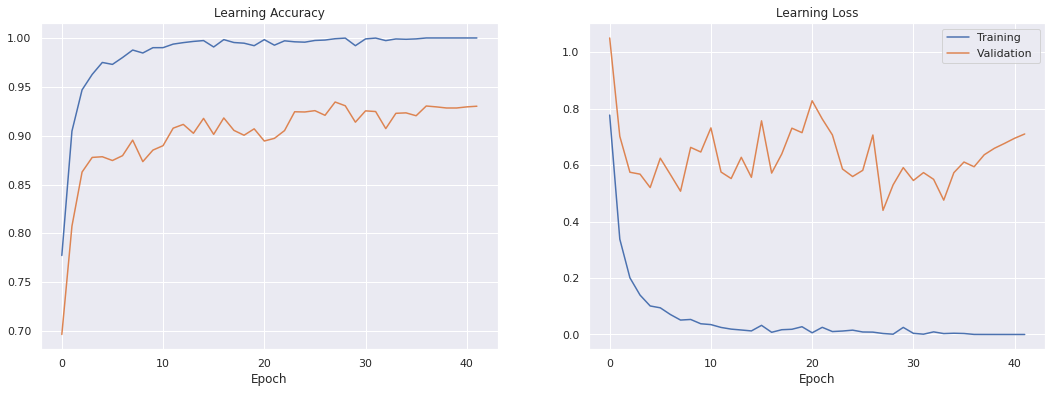

In [26]:
def plot_curve(ax, data, label):
    x = len(data)
    y = np.arange(x)
    ax.plot(y, data, label=label)
    
fig = plt.figure(figsize=(18, 6))
ax=fig.add_subplot(1,2,1)
plot_curve(ax, training_accuracy, "Training")
plot_curve(ax, validation_accuracy, "Validation")
ax.set_title('Learning Accuracy')
plt.xlabel('Epoch')
ax=fig.add_subplot(1,2,2) 
plot_curve(ax, training_loss, "Training ")
plot_curve(ax, validation_loss, "Validation ")
ax.set_title('Learning Loss')
plt.legend()
plt.xlabel('Epoch')
#plt.savefig("learning_curve.png")

# **Test the model**
Once I was happy with my validation accuracy, I performed the final test on the test data.

In [27]:
with tf.compat.v1.Session() as sess:
    saver1.restore(sess, tf.train.latest_checkpoint('.'))

    train_loss, train_accuracy = evaluate(X_train, y_train)
    print("Accuracy Model On Train Images: {:.3f}".format(train_accuracy))
    
    valid_loss, valid_accuracy = evaluate(X_valid, y_valid)
    print("Accuracy Model On Valid Images: {:.3f}".format(valid_accuracy))    
    
    test_loss, test_accuracy = evaluate(X_valid, y_valid)
    print('Accuracy Model On Test Images: {:.3f}'.format(test_accuracy))
     

INFO:tensorflow:Restoring parameters from ./LeNet_Modul


Accuracy Model On Train Images: 1.000
Accuracy Model On Valid Images: 0.930
Accuracy Model On Test Images: 0.930


# **Test a Model on New Images**

In [28]:
!unzip test-traffic-signs.zip

Archive:  test-traffic-signs.zip
 extracting: test-traffic-signs1/.gitkeep  
  inflating: test-traffic-signs1/1x.png  
  inflating: test-traffic-signs1/2x.png  
  inflating: test-traffic-signs1/3x.png  
  inflating: test-traffic-signs1/5x.png  
  inflating: test-traffic-signs1/6x.png  
  inflating: test-traffic-signs1/8x.png  
  inflating: test-traffic-signs1/9x.png  
  inflating: test-traffic-signs1/Teststop.png  


In [ ]:
#reading in an image
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# fig, axs = plt.subplots(2,4, figsize=(4, 2))
# fig.subplots_adjust(hspace = .2, wspace=.001)
# axs = axs.ravel()

my_images = []

for i, img in enumerate(glob.glob('./test-traffic-signs1/*.png')):
    image = cv2.imread(img)
    colored_img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    my_images.append(colored_img)
    plt.axis('off')
    plt.imshow(image)
    plt.figure()


my_New_images= np.asarray(my_images)
for i in range(0, len(my_New_images)):
  my_New_images_Nor[i]=augment_img(my_New_images[i],rectified_train_coords[i])
print(my_New_images.shape)


In [52]:
len(my_New_images)

8

After Normalising


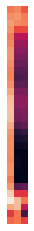

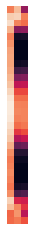

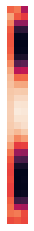

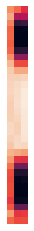

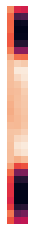

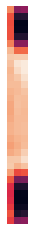

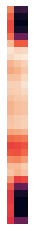

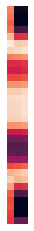

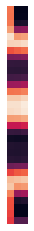

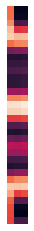

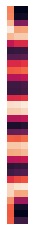

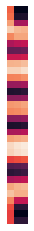

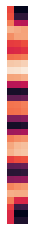

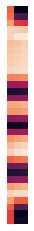

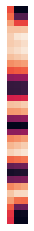

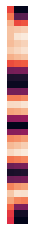

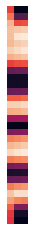

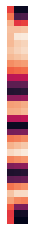

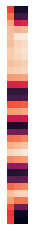

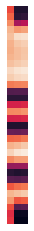

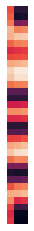

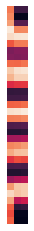

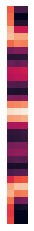

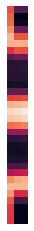

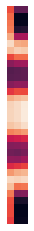

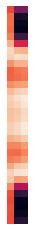

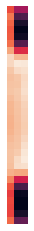

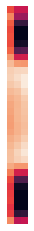

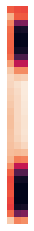

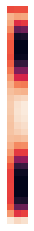

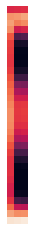

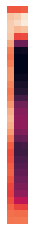

<Figure size 432x288 with 0 Axes>

In [50]:
print("After Normalising")
for i, image in enumerate(my_New_images_Nor):
    plt.imshow(image)
    plt.axis('off')
    plt.figure()

INFO:tensorflow:Restoring parameters from ./LeNet_Modul


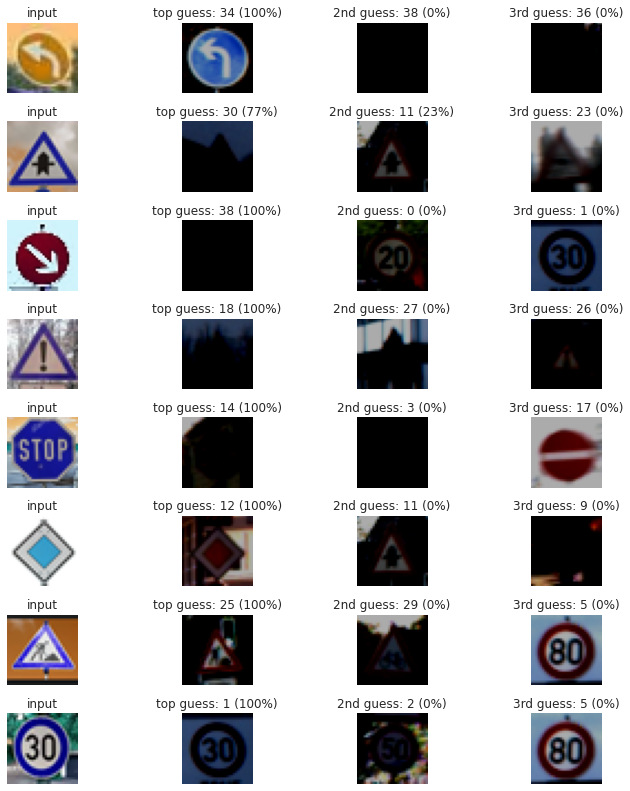

In [32]:
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=3)


with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    saver1 = tf.compat.v1.train.import_meta_graph('./LeNet_Modul.meta')
    saver1.restore(sess, "./LeNet_Modul")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x:my_New_images_Nor})
    my_top_k = sess.run(top_k, feed_dict={x:my_New_images_Nor})

    
    fig, axs = plt.subplots(len(my_images),4, figsize=(12, 14))
    fig.subplots_adjust(hspace = .4, wspace=.2)
    axs = axs.ravel()

    for i, image in enumerate(my_images):
        axs[4*i].axis('off')
        axs[4*i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[4*i].set_title('input')
        guess1 = my_top_k[1][i][0]
        index1 = np.argwhere(y_valid == guess1)[0]
        axs[4*i+1].axis('off')
        axs[4*i+1].imshow(X_valid[index1].squeeze(), cmap='gray')
        axs[4*i+1].set_title('top guess: {} ({:.0f}%)'.format(guess1, 100*my_top_k[0][i][0]))
        guess2 = my_top_k[1][i][1]
        index2 = np.argwhere(y_valid == guess2)[0]
        axs[4*i+2].axis('off')
        axs[4*i+2].imshow(X_valid[index2].squeeze(), cmap='gray')
        axs[4*i+2].set_title('2nd guess: {} ({:.0f}%)'.format(guess2, 100*my_top_k[0][i][1]))
        guess3 = my_top_k[1][i][2]
        index3 = np.argwhere(y_valid == guess3)[0]
        axs[4*i+3].axis('off')
        axs[4*i+3].imshow(X_valid[index3].squeeze(), cmap='gray')
        axs[4*i+3].set_title('3rd guess: {} ({:.0f}%)'.format(guess3, 100*my_top_k[0][i][2]))

In [35]:
"""

my_labels = [11, 1, 12, 38, 34, 18, 25, 14]

with tf.compat.v1.Session() as sess:
    saver1.restore(sess, tf.train.latest_checkpoint('.'))

    accuracy = sess.run(accuracy_operation, feed_dict={
        x: my_New_images_Nor,
        y: my_labels,
    })

    print('Accuracy: {:.6f}'.format(accuracy))

"""

INFO:tensorflow:Restoring parameters from ./LeNet_Modul


Accuracy: 0.125000
